In [1]:
import torch as t
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

In [2]:
t.manual_seed(1)    # reproducible

In [3]:
EPOCH=1
BATCH_SIZE=50
LR=0.001
DOWN_MNIST=False

In [4]:
train_data=torchvision.datasets.MNIST(
            root='./mnist',
            train=True,
            transform=torchvision.transforms.ToTensor(),#將下載的資料轉乘torch格式 在for迴圈會將數值轉為為0到1 
            download=DOWN_MNIST
        )

In [5]:
print('all:',train_data)
print('train_data:',train_data.train_data.shape)
print('train_labels:',train_data.train_labels.shape)

all: Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: ToTensor()
train_data: torch.Size([60000, 28, 28])
train_labels: torch.Size([60000])


D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


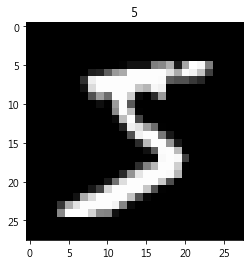

In [6]:
plt.imshow(train_data.train_data[0].numpy(),cmap='gray')
plt.title(train_data.train_labels[0].numpy())
plt.show()

In [7]:
from torch.autograd import Variable as V

In [8]:
train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2 )
#test_data=torchvision.datasets.MNIST(root='./mnist/',train=False)
#test_x=V(t.unsqueeze(test_data.test_data,dim=1),volatile=True).type(t.FloatTensor)[:2000]/255#測試資料要手動轉
#test_y=test_data.test_labels[:2000]

In [9]:
test_data=torchvision.datasets.MNIST(
            root='./mnist',
            train=False,
            transform=torchvision.transforms.ToTensor(),#將下載的資料轉乘torch格式 在for迴圈會將數值轉為為0到1 
            download=DOWN_MNIST
        )

In [10]:
print('all:',test_data)
print('train_data:',test_data.test_data.shape)
print('train_labels:',test_data.test_data.shape)

all: Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist
    Split: Test
    StandardTransform
Transform: ToTensor()
train_data: torch.Size([10000, 28, 28])
train_labels: torch.Size([10000, 28, 28])


D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [11]:
# !!!!!!!! Change in here !!!!!!!!! #
test_x=V(t.unsqueeze(test_data.test_data,dim=1),volatile=True).type(t.FloatTensor)[:2000]/255#測試資料要手動轉

D:\python\envs\two_pthon_deep\lib\site-packages\ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [12]:
# !!!!!!!! Change in here !!!!!!!!! #
test_y=test_data.test_labels[:2000]

D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# 這裡-1表示一個不確定的數，就是你如果不確定你想要reshape成幾行，但是你很肯定要reshape成4列，那不確定的地方就可以寫成-1例如一個長度的16向量x



In [13]:
#再經過捲積層就會變成相乘
#(1,28,28)
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=2),  #(16*28*28)
                        nn.ReLU(),  #(16*28*28)
                        nn.MaxPool2d(kernel_size=2),#(16*14*14)
                    )
            
        self.conv2 = nn.Sequential(
                        nn.Conv2d(16,32,5,1,2),#(32*14*14)
                        nn.Dropout(0.5),
                        nn.ReLU(),#(32*14*14)
                        nn.MaxPool2d(kernel_size=2),#(32*7*7)
                    )
        
        self.out_layer = nn.Linear(32*7*7,50) #n_input,n_output
        self.out_layer2 = nn.Linear(50,10)
        
        
        
    
    def forward(self,x): #(1,28,28)
        x = self.conv1(x) #(16*28*28)
        x = self.conv2(x) #(32*7*7) 
        x = x.view(x.size(0),-1)      #展平成1維，確保為1維的數據
        output=self.out_layer(x) #32*7*7,10
        output=self.out_layer2(output)
        return output 

In [14]:
print(CNN())

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out_layer): Linear(in_features=1568, out_features=50, bias=True)
  (out_layer2): Linear(in_features=50, out_features=10, bias=True)
)


In [15]:
# !!!!!!!! Change in here !!!!!!!!! #
cnn=CNN()



optimizer=t.optim.Adam(cnn.parameters(),lr=LR,)#優化器
loss_func=nn.CrossEntropyLoss() #損失函數

In [16]:
training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

In [17]:
Epoch=0
for epoch in range(2):
    
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        # !!!!!!!! Change in here !!!!!!!!! #
        b_x = V(x)   # batch x
        b_y = V(y)   # batch y
        
        output = cnn(b_x)               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
        b_t_x= V(test_x)
        b_t_y= V(test_y)
        
        
        
        
        
        if step % 100 == 0:
            cnn.eval()
            Epoch+=1
            test_output = cnn(test_x) 
            cnn.train()
            
            # !!!!!!!! Change in here !!!!!!!!! #
            pred_y = t.max(test_output, 1)[1]#因為是relu，所以max取機率最高的機率
            tran_pred_y = t.max(output, 1)[1]
            
            training_loss.append(loss.data)
            val_loss = loss_func(test_output, b_t_y)
            validation_loss.append(val_loss.data)
            
            
            
            
            
            tran_accuracy = (tran_pred_y == y).sum().item() / float(y.size(0))
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            training_accuracy.append(tran_accuracy)
            validation_accuracy.append(accuracy)
            
            
            print('Epoch: ', Epoch, '| train accuracy: %.2f' % tran_accuracy, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy, '- test loss: %.4f' % val_loss.item())


Epoch:  1 | train accuracy: 0.06 | train loss: 2.3022 | test accuracy: 0.17 - test loss: 2.2911
Epoch:  2 | train accuracy: 0.82 | train loss: 0.6828 | test accuracy: 0.86 - test loss: 0.5388
Epoch:  3 | train accuracy: 0.96 | train loss: 0.1867 | test accuracy: 0.93 - test loss: 0.2709
Epoch:  4 | train accuracy: 0.96 | train loss: 0.1740 | test accuracy: 0.95 - test loss: 0.2090
Epoch:  5 | train accuracy: 0.92 | train loss: 0.2930 | test accuracy: 0.96 - test loss: 0.1693
Epoch:  6 | train accuracy: 0.96 | train loss: 0.0826 | test accuracy: 0.96 - test loss: 0.1511
Epoch:  7 | train accuracy: 0.94 | train loss: 0.1580 | test accuracy: 0.96 - test loss: 0.1429
Epoch:  8 | train accuracy: 0.98 | train loss: 0.1036 | test accuracy: 0.97 - test loss: 0.1111
Epoch:  9 | train accuracy: 0.98 | train loss: 0.1485 | test accuracy: 0.98 - test loss: 0.1111
Epoch:  10 | train accuracy: 0.94 | train loss: 0.1647 | test accuracy: 0.98 - test loss: 0.1065
Epoch:  11 | train accuracy: 0.98 | tra

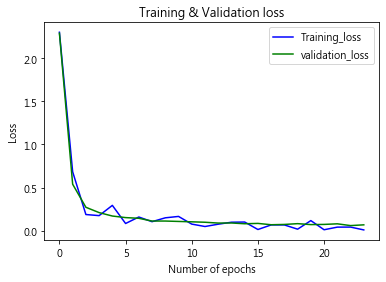

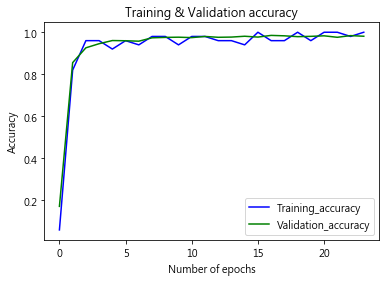

In [18]:
plt.plot(training_loss, 'b-', label='Training_loss')
plt.plot(validation_loss, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot( training_accuracy, 'b-', label='Training_accuracy')
plt.plot( validation_accuracy, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
y_0_9_chance=cnn(test_x[:20])
y_pred=t.max(y_0_9_chance,1)[1].data.numpy().squeeze()

In [20]:
print('實際:',test_y[:20].numpy())
print('預測:',y_pred)

實際: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
預測: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [21]:
from sklearn.metrics import classification_report

In [22]:
y_all=cnn(test_x)
y_pred_all=t.max(y_all,1)[1].data.numpy().squeeze()

In [23]:
target_names = ['0', '1', '2','3','4','5','6','7','8','9']

In [24]:
print(classification_report(test_y.numpy(),y_pred_all,target_names=target_names))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       175
           1       0.99      0.99      0.99       234
           2       0.97      1.00      0.98       219
           3       0.97      0.99      0.98       207
           4       0.99      0.99      0.99       217
           5       0.96      0.99      0.97       179
           6       0.99      0.97      0.98       178
           7       0.99      0.94      0.96       205
           8       0.98      0.98      0.98       192
           9       0.98      0.97      0.98       194

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
confmat = confusion_matrix(y_true=test_y.numpy(), y_pred=y_pred_all)
print(confmat)

[[174   0   0   0   0   0   1   0   0   0]
 [  0 232   0   0   0   1   0   0   1   0]
 [  0   1 218   0   0   0   0   0   0   0]
 [  0   0   0 205   0   2   0   0   0   0]
 [  2   0   0   0 214   0   0   0   0   1]
 [  0   0   0   1   0 177   0   1   0   0]
 [  2   0   0   0   0   2 172   0   2   0]
 [  0   1   5   5   0   1   0 192   0   1]
 [  1   0   1   1   0   0   0   0 188   1]
 [  0   0   0   0   3   2   0   0   1 188]]
